# News Summarization with an Attention Mechanism and Transformer Model
Author: Andrii Zapukhlyi

## Objective

## Solution

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import evaluate

import datasets
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSeq2SeqLM

## Dataset overview

In [60]:
dataset = datasets.load_dataset("cnn_dailymail", "3.0.0")

In [61]:
train = pd.DataFrame(dataset["train"])
test = pd.DataFrame(dataset["test"])
val = pd.DataFrame(dataset["validation"])

In [62]:
train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [63]:
print(len(train), len(val), len(test))

287113 13368 11490


In [64]:
train = train.head(50000)

In [65]:
train.sample(10)

,article,highlights,id
12175,(CNN) -- Two miners who died this week in a Ne...,"NEW: Two dead miners survived by spouses, chil...",cbce8bdb0f6be79786de1b138d4ecc53e0d56db7
35287,Washington (CNN) -- A Salvadoran national want...,Suspect in the slaying of a Colorado man added...,e5757ec07d9cf031f14e8e291a6de022d7088a2c
3692,(CNN) -- Is the movie cop thriller heading fo...,"""Pride and Glory"" wants to be cop thriller thr...",b648d49d4e487f0dc4b8fb0377ca61ff6b43b6da
13107,(CNN) -- I lived through 9/11. Now I live two ...,John Avlon went to protests over Islamic cente...,1b91e40f279fa7e5a74ee456c1005e9b2d4c4cf4
7073,"Perugia, Italy (CNN) -- Family members of Mere...","NEW: Sentence makes no sense, co-defendant's l...",086977dad90c35858d511066f62bcab319ec9d15
38915,"(CNN) -- As his family, friends and co-stars m...","""Glee"" producers must now decide how to handle...",d2e1b9853385c1fe1408209f5adfb00533d1a930
33095,"(CNN) -- For years, Republican presidents and ...",Carrie Rickey: Clint Eastwood lines have long ...,074861ff223d281acceeb323a8695cebd0fda662
19655,New York (CNN) -- Just as it has happened for ...,"Since 1907, a ball-drop in Times Square has ma...",4fb544540980760c89f190b5bb503b7b3a3dbbdc
25746,"(WIRED) -- Gerald ""Jerry"" Lawson, creator of t...",Jerry Lawson passed away after suffering a hea...,a37009289e0fc1effc19a67eeae03e01e65b8c77
5071,"(CNN) -- Police in Allendale, South Carolina, ...","At 6'5'', former employee says James Hines was...",ecf828688125c468450a0fcd74c45f2793aed007


In [70]:
train.describe()

,article,highlights,id
count,49764,49764,49764
unique,47647,47509,49764
top,(CNN) -- Dubai could lose its place on the Wom...,Rick Steves writes European travel guidebooks ...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
freq,3,8,1


In [69]:
def delete_wrong_scraped(set):
    wrong_scraped = ["This page includes the show Transcript", "The daily transcript is a written version", "Use the weekly Newsquiz to test your", "Use these questions to help students understan"]

    for elem in wrong_scraped:
        set = set[~set['highlights'].str.contains(elem, na=False, case=False)]

    return set

train = delete_wrong_scraped(train)
val = delete_wrong_scraped(val)
test = delete_wrong_scraped(test)

In [13]:
print(train.describe())
print(val.describe())
print(test.describe())

                                                  article  \
count                                               49764   
unique                                              47647   
top     (CNN) -- Dubai could lose its place on the Wom...   
freq                                                    3   

                                               highlights  \
count                                               49764   
unique                                              47509   
top     Rick Steves writes European travel guidebooks ...   
freq                                                    8   

                                              id  
count                                      49764  
unique                                     49764  
top     42c027e4ff9730fbb3de84c1af0d2c506e41c3e4  
freq                                           1  
                                                  article  \
count                                               13351   
unique     

In [14]:
print("Number of NA values in sets:")
print(train.isna().sum().sum())
print(val.isna().sum().sum())
print(test.isna().sum().sum())

print("Number of duplicates in sets:")
print(train.duplicated().sum())
print(val.duplicated().sum())
print(test.duplicated().sum())

Number of NA values in sets:
0
0
0
Number of duplicates in sets:
0
0
0


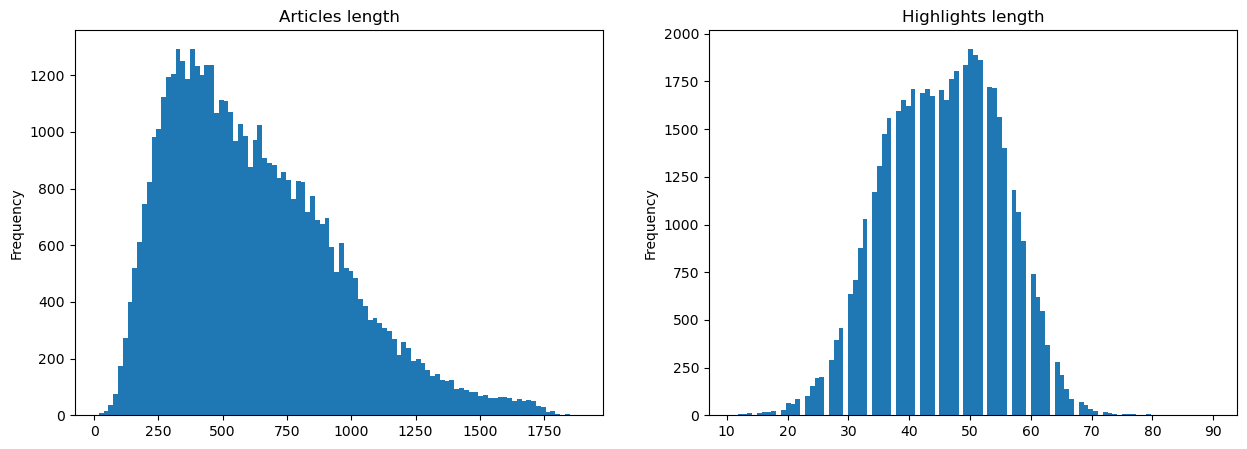

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

train["article"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100, ax = ax[0])
ax[0].set_title('Articles length')

train["highlights"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100)
ax[1].set_title('Highlights length')

plt.show()

In [ ]:
text_data = " ".join(train['highlights'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=1000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

'from wordcloud import WordCloud\n\ntext_data = " ".join(train[\'highlights\'])\n\nwordcloud = WordCloud(width=800, height=400, background_color=\'white\', colormap=\'viridis\', max_words=1000).generate(text_data)\n\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud)\nplt.axis("off")\nplt.show()'

In [ ]:
stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in train["highlights"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

'from nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nimport nltk\nfrom collections import Counter\nimport nltk\n\nstop_words = set(stopwords.words("english"))\n\ndef get_bigrams(text):\n    words = word_tokenize(text.lower())\n    words = [word for word in words if word.isalnum() and word not in stop_words]\n    bigrams = list(nltk.bigrams(words))\n    return [" ".join(bigram) for bigram in bigrams]\n\nbigrams = []\nfor t in train["highlights"]:\n    bigrams.extend(get_bigrams(t))\n\nbigram_counts = Counter(bigrams).most_common(10)\nbigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])\n\nplt.figure(figsize=(10, 5))\nsns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")\nplt.title("Top 10 Most Common Bigrams (Without Stopwords)")\nplt.show()'

## Data preprocessing

In [6]:
metadata_pattern = re.compile(
    r"^By\s+.*?\.\s+"  # Removes "By . Author Name ."
    r"|PUBLISHED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*\s*\|?\s*UPDATED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*"  # Removes PUBLISHED / UPDATED timestamps
    r"|Last updated at \d{1,2}:\d{2} [APM]{2} on \d{1,2}(st|nd|rd|th)? \w+ \d{4} \."  # Removes "Last updated at ..."
    r"|^.*?--\s*"  # Removes source prefixes like "(CNN) --", "(BBC) --"
    r"|^Follow\s+@@\S+\s+\.\s+"  # Removes "Follow @username . "
    r"|UPDATED: .*? \. "  # Removes text after "UPDATED: ..."
)

def delete_metadata(text):
    if not isinstance(text, str):
        return text
    
    text = metadata_pattern.sub('', text)
    return ' '.join(text.split())

train["article"] = train["article"].apply(delete_metadata)
val["article"] = val["article"].apply(delete_metadata)

NameError: name 'train' is not defined

In [19]:
def clean_text(text_series):
    text_series = text_series.str.lower()

    text_series = text_series.str.replace(r"http\S+|www\S+|https\S+", '', regex=True)
    text_series = text_series.str.replace(r"@\w+|#\w+", '', regex=True)
    text_series = text_series.str.replace(r"([.,!?])", r" \1 ", regex=True)
    text_series = text_series.str.replace(r'\n+', ' ', regex=True)
    text_series = text_series.str.strip()
    return text_series

train["article"] = clean_text(train["article"])
train["highlights"] = clean_text(train["highlights"])

val["article"] = clean_text(val["article"])
val["highlights"] = clean_text(val["highlights"])

In [20]:
train = train.dropna()
val = val.dropna()

In [ ]:
nlp = spacy.load("en_core_web_sm")

def tokenize_text(texts):
    texts = list(texts)
    return [[token.text for token in doc] for doc in nlp.tokenizer.pipe(texts, batch_size=128)]

X_train_tokenized = tokenize_text(train["article"])
y_train_tokenized = tokenize_text(train["highlights"])
X_val_tokenized = tokenize_text(val["article"])
y_val_tokenized = tokenize_text(val["highlights"])

In [ ]:
all_tokens = [token for tokens in (X_train_tokenized + y_train_tokenized) for token in tokens]
word_counts = Counter(all_tokens)

vocab = {
    "<PAD>": 0,
    "<UNK>": 1,
    "<SOS>": 2,
    "<EOS>": 3
}

start_idx = 4

for token, _ in word_counts.most_common():
    if token not in vocab:
        vocab[token] = start_idx
        start_idx += 1

def encode(tokens, vocab):
    return np.array([vocab.get(token, vocab["<UNK>"]) for token in tokens], dtype=np.int32)

X_train_idx = [encode(tokens, vocab) for tokens in X_train_tokenized]
Y_train_idx = [encode(tokens, vocab) for tokens in y_train_tokenized]
X_val_idx = [encode(tokens, vocab) for tokens in X_val_tokenized]
Y_val_idx = [encode(tokens, vocab) for tokens in y_val_tokenized]

In [ ]:
MAX_LEN = 10000

def pad_sequences(sequences, max_len=MAX_LEN, pad_idx=0):
    tensor_sequences = [torch.tensor(seq[:max_len], dtype=torch.long) for seq in sequences]
    return pad_sequence(tensor_sequences, batch_first=True, padding_value=pad_idx)

X_train_padded = pad_sequences(X_train_idx, pad_idx=vocab["<PAD>"])
Y_train_padded = pad_sequences(Y_train_idx, pad_idx=vocab["<PAD>"])
X_val_padded = pad_sequences(X_val_idx, pad_idx=vocab["<PAD>"])
Y_val_padded = pad_sequences(Y_val_idx, pad_idx=vocab["<PAD>"])

In [24]:
print(X_train_padded.shape, Y_train_padded.shape) 

torch.Size([49764, 2947]) torch.Size([49764, 114])


## LSTM model

In [25]:
class SummarizationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = SummarizationDataset(X_train_padded, Y_train_padded)
val_dataset = SummarizationDataset(X_val_padded, Y_val_padded)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        _, (hidden, cell) = self.rnn(embedding)
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        predictions = self.fc(output.squeeze(1))
        return predictions, hidden, cell
    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
num_epochs = 3
num_batches = len(train_loader)
total_batches = num_epochs * num_batches

In [44]:
encoder = Encoder(len(vocab), 256, 256, 1)
decoder = Decoder(len(vocab), 256, 256, 1)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-03)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<PAD>"])

model.train()
torch.cuda.empty_cache()

start_time = time.time()

X_batch, y_batch = next(iter(train_loader))
batch_start_time = time.time()

X_batch, y_batch = X_batch.to(device), y_batch.to(device)
optimizer.zero_grad()
output = model(X_batch, y_batch)
output = output[:, 1:].reshape(-1, output.shape[2])
y_batch = y_batch[:, 1:].reshape(-1)

loss = criterion(output, y_batch)
loss.backward()
optimizer.step()

batch_time = time.time() - batch_start_time
elapsed_time = time.time() - start_time
estimated_total_time = (elapsed_time * total_batches)
print(f"Batch 1/1 - Time per batch: {batch_time:.2f}s - Estimated Total: {estimated_total_time // 60:.2f} min")

Batch 1/1 - Time per batch: 12.03s - Estimated Total: 938.00 min


## LSTM with an Attention Mechanism (for practice)

## Transformer model

In [3]:
dataset = datasets.load_dataset("cnn_dailymail", "3.0.0")

In [4]:
train_data = dataset["train"].select(range(50000))
val_data = dataset["validation"]

In [8]:
def delete_wrong_scraped(example):
    wrong_scraped = [
        "This page includes the show Transcript", 
        "The daily transcript is a written version", 
        "Use the weekly Newsquiz to test your", 
        "Use these questions to help students understan"
    ]
    
    for elem in wrong_scraped:
        if isinstance(example["highlights"], str) and elem.lower() in example["highlights"].lower():
            return None
    return example

def clean_text(example):
    example["article"] = delete_metadata(example["article"])
    example["highlights"] = delete_metadata(example["highlights"])
    return delete_wrong_scraped(example)


train_data = train_data.map(clean_text, batched=False)
val_data = val_data.map(clean_text, batched=False)

Map:   0%|          | 0/49764 [00:00<?, ? examples/s]

Map:   0%|          | 0/13351 [00:00<?, ? examples/s]

In [9]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def tokenize_data(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=128)
    
    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(tokenize_data, batched=True)
val_data = val_data.map(tokenize_data, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/49764 [00:00<?, ? examples/s]

Map:   0%|          | 0/13351 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 8

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

In [11]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Total Parameters: 60,506,624
Trainable Parameters: 60,506,624


In [12]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.280800,1.332767
2,1.264800,1.324153
3,1.225500,1.319207


TrainOutput(global_step=18663, training_loss=1.2734535829255558, metrics={'train_runtime': 1458.4706, 'train_samples_per_second': 102.362, 'train_steps_per_second': 12.796, 'total_flos': 2.0205448225357824e+16, 'train_loss': 1.2734535829255558, 'epoch': 3.0})

In [26]:
model = AutoModelForSeq2SeqLM.from_pretrained("results/checkpoint-18750")
model.to("cuda")

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [13]:
def summarize(text, max_input_length=512, max_output_length=128, device="cuda"):
    model.to(device)

    inputs = tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        summary_ids = model.generate(
            **inputs, 
            max_length=max_output_length, 
            num_beams=5, 
            early_stopping=True
        )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [14]:
sample_text = val_data["article"][3]
summary = summarize(sample_text)
print("Original Article:\n", sample_text)
print("\nGenerated Summary:\n", summary)


Original Article:
 (CNN)It was an act of frustration perhaps more commonly associated with golf's fictional anti-hero Happy Gilmore than the world's reigning No 1. player. But when Rory McIlroy pulled his second shot on the eighth hole of the WGC Cadillac Championship into a lake Friday, he might as well have been channeling the much loved Adam Sandler character. Before continuing his round with a dropped ball, the four-time major winner launched the 3-iron used to play the offending shot into the water as well. "(It) felt good at the time," a rueful McIlroy later said of the incident in comments carried by the PGA Tour website. "I just let frustration get the better of me. It was heat of the moment, and I mean, if it had of been any other club I probably wouldn't have but I didn't need a 3‑iron for the rest of the round so I thought, why not." The club "must have went a good 60, 70 yards," he joked. McIlroy composed himself to finish with a second round of 70, leaving him one-under fo

In [15]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def compute_metrics(predictions, references):
    predictions = [pred.strip() for pred in predictions]
    references = [[ref.strip()] for ref in references]

    bleu_score = bleu_metric.compute(predictions=predictions, references=references)
    rouge_score = rouge_metric.compute(predictions=predictions, references=references)

    return {"bleu": bleu_score["bleu"], "rouge": rouge_score}

predictions = [summarize(article) for article in val_data["article"][:10]]
references = [ref for ref in val_data["highlights"][:10]]


metrics = compute_metrics(predictions, references)
print(metrics)

{'bleu': 0.030677867325323214, 'rouge': {'rouge1': 0.17233953021510848, 'rouge2': 0.027947218729782848, 'rougeL': 0.140742478947466, 'rougeLsum': 0.14172978245897916}}


In [16]:
samplex_text = """

A unique report on a secret Soviet-era military facility reveals the details of an underground command post hidden in the forests near Ivano-Frankivsk, which could once have become the epicenter of a global confrontation.

Halka writes about this with reference to video blogger Mark Bobalik in his study of abandoned military facilities in the Carpathian region.

The hidden heart of the Cold War, a huge underground complex that could once accommodate 450 top military officials and withstand a powerful nuclear strike, has now turned into a terrifying monument to Soviet military power. Located in the picturesque Black Forest near Ivano-Frankivsk, this top-secret facility was a real fortress, capable of operating autonomously for three weeks.

The command post was a true engineering masterpiece of the Soviet era. Suspended on 36 steel cables, with a unique nitrogen shock absorption system, it was designed to withstand even the most powerful impacts. Special cylinders maintained internal pressure, preventing the ingress of toxic substances, and the furniture was securely fixed on a special raised floor with foam filler.

The uniqueness of the facility lay in its communication capabilities. From here, the troops of 15 Warsaw Pact countries were controlled, 600 telephone and one and a half thousand telegraph channels operated. The system was duplicated by radio communication, relay, tropospheric and space communication channels.

Interestingly, in 2005, the local authorities planned to transform the unique complex into a tourist and recreational facility and a center for medical prevention. However, these plans remained unrealized. Currently, the premises are under the management of the State Emergency Service and are used as ordinary warehouses.

Mark Bobalik recorded the condition of the facility during his research: flooded tunnels, damaged metal structures, complete lack of security. Once the pride of Soviet military power, it has turned into a terrible monument of the past, a silent witness to the Cold War era.

Today, only fragments remain of its former greatness: damaged entrances, cut-off antennas and flooded premises. The only thing that has remained unchanged is the picturesque forest lands around, where the largest population of red deer in the Carpathian region still lives.

This facility is not just an abandoned place, but a real museum of Soviet-era technical thought, waiting for its rebirth and rethinking.
"""

In [17]:
summarize(samplex_text)

'A secret Soviet-era military facility is hidden in the forests near Ivano-Frankivsk. It was a real fortress capable of operating autonomously for three weeks. The complex was a true engineering masterpiece of the Soviet era.'

In [19]:
compute_metrics([summarize(val_data["article"][3])], [(val_data["highlights"][3])])

{'bleu': 0.05060454076656146,
 'rouge': {'rouge1': 0.19753086419753085,
  'rouge2': 0.10126582278481013,
  'rougeL': 0.19753086419753085,
  'rougeLsum': 0.19753086419753085}}

In [20]:
summarize(val_data["article"][3])

'Rory McIlroy pulls his second shot on the eighth hole of the WGC Cadillac Championship. The four-time major winner launches the 3-iron used to play the offending shot into the water. McIlroy finished with a second round of 70, leaving him one-under for the tournament. Ryan Holmes scores a two-under-par 71 to remain in second position overall.'

In [21]:
val_data["highlights"][3]

'Rory McIlroy throws club into water at WGC Cadillac Championship . Northern Irishman frustrated after pulling shot into water hazard .'